# 1 Draw map of Germany with folium
read list of current gas stations into dataframe (generator?) -> initialization

Bert Carremans - https://towardsdatascience.com/visualizing-air-pollution-with-folium-maps-4ce1a1880677 

create color scale: http://colorbrewer2.org/#type=diverging&scheme=RdBu&n=10

optimization for speed: https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6

https://blog.dominodatalab.com/creating-interactive-crime-maps-with-folium/

https://blog.prototypr.io/interactive-maps-with-python-part-1-aa1563dbe5a9

https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-series

In [43]:
import folium # mapping
from folium.plugins import TimestampedGeoJson # create timeseries with folium
import folium.plugins as plugins
import pandas as pd # data handling
import glob # Filename pattern matching
import os # OS interfaces
from pathlib import Path # ?
import seaborn as sns # visualization
from datetime import datetime # 
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
# create some boundaries to keep the amount of data manageble
center = [51.9481, 10.26517] # center of map/Germany
box = [52.6739, 13.6917, 52.3700, 13.1094] # N/E/S/W -> boundaries for Berlin/Brandenbrug region
bln_ctr = [52.49, 13.36]
pdm_ctr = [52.3976, 13.0598]
bln_box = [[box[2], box[1]], [box[2], box[3]], [box[0], box[3]], [box[0], box[1]], [box[2], box[1]]]

In [45]:
# define functions
def date_to_df(date):
    '''returns the content of a csv for specified date into a dataframe'''
    year = (date).strftime('%Y')
    month = (date).strftime('%m')
    day = (date).strftime('%d')
    
    with open(r'C:\Users\vince\Data Science Class\gas prices project\{0}\{1}\{0}-{1}-{2}-prices.csv'.format(year, month, day)) as f:
        file = pd.read_csv(f)
        return file

# --> filter by city = "Berlin"?
def cut_pumps(pumps):
    '''select only pumps that are in the Berlin region to keep the dataset lean'''
    #pumps_crop = pumps[(pumps["latitude"].between(box[2], box[0])) & (pumps["longitude"].between(box[3], box[1]))]
    pumps_crop = pumps[(pumps["city"] == "Berlin")]
    pumps_crop.drop('station_uuid', axis=1, inplace = True)
    pumps_crop.reset_index(inplace = True)
    return pumps_crop

def date_to_path(date):
    year = date.strftime('%Y')
    month = date.strftime('%m')
    day = date.strftime('%d')
    path = (r'C:\Users\vince\Data Science Class\gas prices project\{0}\{1}\{0}-{1}-{2}-prices.csv'.format(year, month, day))
    print('> Done.')
    return path

#from https://towardsdatascience.com/visualizing-air-pollution-with-folium-maps-4ce1a1880677

def create_geojson_features(df):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['longitude'],row['latitude']]
            },
            'properties': {
                'time': row['dates'].date().__str__() + ' ' + row['dates'].time().__str__(),
                'style': {'color': row['colors']},
                'icon': 'circle',
                'popup': str(row['brand']) + ' ' + str(row['e5_rounded']) + ' €',
                'iconstyle':{
                    'fillColor': row['colors'],
                    'fillOpacity': 1.0,
                    'stroke': 'true',
                    'radius': 7
                }
            }
        }
        
        features.append(feature)
    print('> Done!')
    return features

def make_map(features):
    print('> Making map...')
    gas_price_map = folium.Map(location = center, 
    #tiles='Stamen Toner',
    control_scale = True, zoom_start = 7, prefer_canvas = True)

    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features},
        period = 'PT20M',#'PT5M',
        add_last_point =  True,
        auto_play = False,
        loop = False,
        max_speed = 500,
        loop_button = True,
        date_options = 'YYYY/MM/DD - HH:mm:ss',
        time_slider_drag_update = True,
    ).add_to(gas_price_map)
    print('> Done.')
    return gas_price_map

In [46]:
# import data
path = r'C:\Users\vince\Data Science Class\gas prices project\2019\05'

all_files = glob.glob(os.path.join(path, '*.csv'))

df_from_each_file = (pd.read_csv(f) for f in all_files)
week_df   = pd.concat(df_from_each_file, ignore_index=True)
pumps = pd.read_csv('2019-05-19-stations.csv')

In [47]:
pumps3 = pd.read_csv('2019-05-19-stations.csv')
pumps3 = pumps3[(pumps3["city"] == "BERLIN") ]#& (pumps3['city'] == '*')]
len(pumps3)

140

In [48]:
def cleanup(time, pumps, city, fraction):
    pumps['city'] = pumps['city'].str.lower()
    pumps['openingtimes_json'] = pumps[pumps['openingtimes_json'] == '']
    pumps = pumps[(pumps['city']) == city]
    pumps_crop = pumps.sample(int(len(pumps)* fraction))
    pumps_crop.reset_index(inplace = True)
    
    time = time[time['e5'] != 0]
    pumps_merged = pd.merge(pumps_crop[['uuid', 'brand', 'latitude', 'longitude', 'city']], time[['date', 'station_uuid', 'diesel', 'e5', 'e10']],  left_on='uuid', right_on='station_uuid')
    pumps_merged['e5_rounded'] = pumps_merged['e5'].round(2)
    
    pumps_merged.drop('station_uuid', axis=1, inplace = True)
    pumps_merged['dates'] = pd.to_datetime(pumps_merged['date'], format='%Y-%m-%d %H:%M:%S')
    pumps_merged['colors'] = pd.cut(pumps_merged['e5_rounded'], bins = 15, labels = [
'#08306b', # blue
'#08519c',
'#2171b5',
#'#4292c6',
'#6baed6',
'#9ecae1',
#'#c6dbef',
'#deebf7',
'#f7fbff',
#'#ffffff', # white
'#fff5f0',
'#fee0d2',
#'#fcbba1',
'#fc9272',
'#fb6a4a',
#'#ef3b2c',
'#cb181d',
'#a50f15',
'#67000d',# red
'#000000' # black
          ])
    return pumps_merged

In [49]:
def mapmaker(week_df, pumps, city, fraction):
    '''create a map with colorful bubbles. input: gas prices | list of pumps | city | fraction of pumps (max. 0.05 for whole country)'''
    week_city = cleanup(week_df, pumps, city, fraction)
    features_city = create_geojson_features(week_city)
    m_city = make_map(features_city)
    m_city.save(outfile=r'{0}_{1}.html'.format(city, datetime.date.today()))
    return print(r' Map {0}_{1}.html created'.format(city, datetime.date.today()))

In [53]:
mapmaker(week_df, pumps, 'essen', 1)

> Creating GeoJSON features...
> Done!
> Making map...
> Done.
 Map essen_2019-05-22.html created


In [24]:
city = 'potsdam'
week_city = cleanup(week_df, pumps, city, 0.1)
features_city = create_geojson_features(week_city)
m_city = make_map(features_city)
m_city.save(outfile = r'{0}_{1}.html'.format(city, datetime.date.today()))

> Creating GeoJSON features...
> Done!
> Making map...
> Done.


In [16]:
week_ger = cleanup(week_df, pumps, 'city', 0.01)
features_ger = create_geojson_features(week_ger)
map_germany = make_map(features_ger)
map_germany.save(outfile= 'Germany.html')

ValueError: a must be greater than 0

In [ ]:
day = pd.read_csv(r'C:\Users\vince\Data Science Class\gas prices project\2019\05\2019-05-19-prices.csv')
df_ger = cleanup(day, pumps, "potsdam")
len(df_ger)

In [ ]:
#features_ger = create_geojson_features(df_ger)

#features_df[1]
len(features_ger)

In [ ]:
m_ger = make_map(features_ger)

In [ ]:
m_ger.save(outfile='germany_1perc_2019-05-19.html')

# Data exploration

In [ ]:
pumps_pivot = df.copy()
pumps_pivot['dates'] = pd.to_datetime(pumps_pivot['date'], format='%Y-%m-%d %H:%M:%S')# infer_datetime_format=True)
#pumps_pivot['dates'] = pd.DatetimeIndex(pumps_pivot['date'], format='%Y-%m-%d %H:%M:%s')

In [782]:
pumps_pivot = pumps_pivot.pivot(index = 'dates', columns = 'uuid', values = 'e5_rounded')
pumps_pivot = pumps_pivot.fillna(method='ffill').ffill()#.last()#.reset_index()

In [783]:
pumps_pivot.tail()

uuid,005056ba-7cb6-1ed5-8cbd-4897fe54e42b,140b41f2-fc48-4c08-8461-68be5dc1b491,22d3f644-fa21-4ed6-ae1f-3547d8cd9227,2738df4a-0b19-423b-81b1-3912d53b69fb,3e17a2ae-db29-425f-895d-f841d817309a,51d4b4f2-a095-1aa0-e100-80009459e03a,51d4b5c3-a095-1aa0-e100-80009459e03a,51d4b5df-a095-1aa0-e100-80009459e03a,51d4b5e9-a095-1aa0-e100-80009459e03a,51d4b650-a095-1aa0-e100-80009459e03a,5671832b-77cb-430e-8b61-87c2e34dd284,676ae5d2-565c-47e9-a70f-0708bf01b374,815f1e60-6564-4f74-b497-371e9e2ef99b,a08e4d7e-8159-4f85-a299-0885478c8186,c7866e1a-f5f7-409d-8913-a88132310021,e1a15081-2597-9107-e040-0b0a3dfe563c,e1d851d8-c763-425c-b727-f01fdec36cf3
dates,,,,,,,,,,,,,,,,,
2019-05-19 21:57:06+02:00,1.49,1.50,1.5,1.54,1.56,1.49,1.49,1.49,1.49,1.49,1.5,1.50,1.54,1.52,1.56,1.49,1.56
2019-05-19 22:00:06+02:00,1.49,1.56,1.5,1.59,1.61,1.49,1.49,1.49,1.49,1.49,1.5,1.56,1.59,1.57,1.56,1.49,1.56
2019-05-19 22:17:06+02:00,1.49,1.56,1.5,1.59,1.61,1.49,1.49,1.49,1.49,1.49,1.5,1.56,1.59,1.57,1.56,1.49,1.56
2019-05-19 22:51:06+02:00,1.49,1.56,1.5,1.59,1.61,1.49,1.52,1.52,1.49,1.49,1.5,1.56,1.59,1.57,1.56,1.49,1.56
2019-05-19 22:52:06+02:00,1.49,1.56,1.5,1.59,1.61,1.49,1.52,1.52,1.52,1.49,1.5,1.56,1.59,1.57,1.56,1.49,1.56


In [829]:
pumps_pivot_pres = pres_df.copy()
pumps_pivot_pres['dates'] = pd.to_datetime(pumps_pivot_pres['date'], format='%Y-%m-%d %H:%M:%S')

In [830]:
pumps_pivot_pres = pumps_pivot_pres.pivot(index = 'dates', columns = 'uuid', values = 'e5_rounded')
pumps_pivot_pres = pumps_pivot_pres.fillna(method='ffill').ffill()#.last()#.reset_index()

In [831]:
pumps_t_pres = pumps_pivot_pres.T

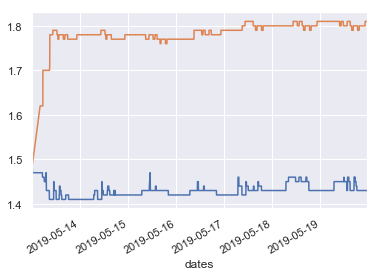

In [832]:
pumps_t_pres.min().plot()
pumps_t_pres.max().plot()
plt.savefig('minmax_week.pdf',format='pdf') 

In [773]:
pumps_pivot['minmax'] = pumps_pivot.max -- pumps_pivot.min

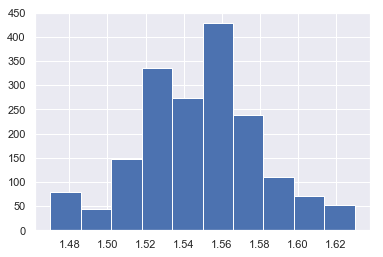

In [775]:
#pumps_pivot.hist()
pumps_pivot["140b41f2-fc48-4c08-8461-68be5dc1b491"].hist()

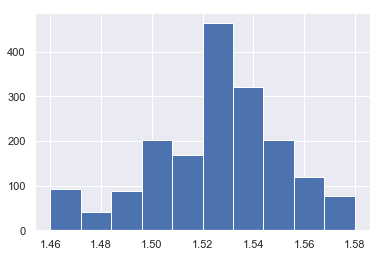

In [776]:
pumps_pivot["51d4b4f2-a095-1aa0-e100-80009459e03a"].hist()

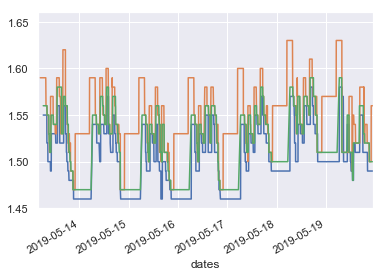

In [272]:
#ax = sns.lineplot(x="dates", y="e5_rounded", hue="uuid", data=pumps_pivot)
pumps_sample = pumps_pivot.iloc[:, 0:3]

diag = pumps_sample.plot(ylim = (1.45, 1.66), legend=False)
plt.savefig('week_sample.pdf',format='pdf') 

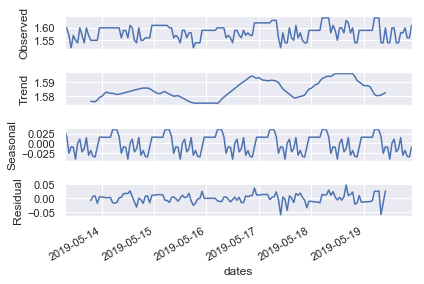

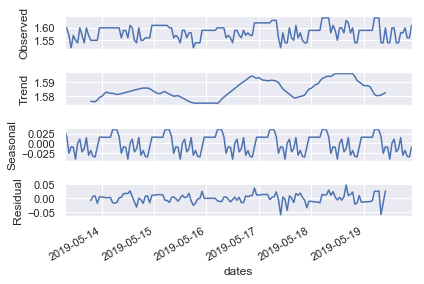

In [564]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(zucki['price'], model = 'additive').plot()

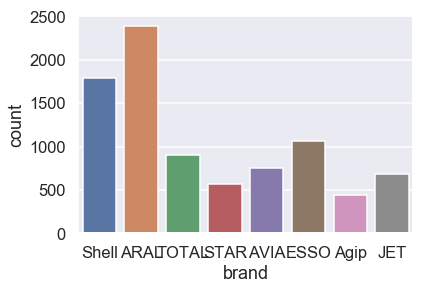

In [369]:
# data exploration:
# return number of stations of specific brand
# pumps.groupby([pumps['brand']]).size()
# aral_shell = pumps[(pumps["brand"] == "ARAL") | (pumps["brand"] == "Shell")]
#len(pumps[pumps["brand"] == "Shell"])
#aral_shell['brand'].groupby(aral_shell['brand']).count()
top_brands = pumps.groupby("brand").filter(lambda x: len(x) > 400)
sns.set(style="darkgrid")
sns.set_context("talk")
sns.countplot(x="brand", data=top_brands)

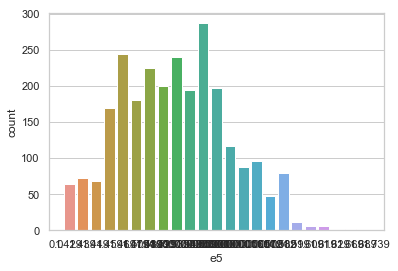

In [67]:
sns.countplot(x="e5", data=pumps_final)